In [1]:
polarized_topics = ["kokoomus", 
                    "vihreät", 
                    "perussuomalaiset", 
                    "vasemmisto", 
                    "vihapuhe", 
                    "ilmastonmuutos", 
                    "maahanmuutto",
                    "sote",
                    "ilmastovaalit",
                    "keskusta"]

unpolarized_topics = ["mielenterveys", 
                      "liikenne", 
                      "kunnat", 
                      "tekoäly", 
                      "nuoret", 
                      "urheilu", 
                      "yrittäjät",
                      "yrittäjyys",
                      "rekry",
                      "osaaminen",
                      "johtaminen"]

selected_topics = polarized_topics+unpolarized_topics

In [2]:
import cpalgorithm as cpa
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import collections
import pandas as pd
from scipy.stats import wasserstein_distance, energy_distance
plt.style.use('ggplot')

### DATA 

*A better data reading process should be figured out later*

In [3]:
def easier_indexing(Gs):
    """
        Quick tool for easier indexing 
    """
    keys = [Gs[i][1][:-5] for i in range(len(Gs))]
    topic_dict = dict(zip(keys, list(range(len(keys)))))
    return topic_dict

In [4]:
GL = pickle.load(open("data/graphlistnew.pickle", "rb" ))
topic_dict = easier_indexing(GL)

In [ ]:
all_topics = list(topic_dict.keys())
network = GL[topic_dict["kokoomus"]][0][0][0]
print(nx.info(network))

***

# RAW PIPELINE TO MEASURE CORE POLARIZATION AND BUBBLE COHESION

*The pipeline can (and will) be made faster and smoother*

### I. IDENTIFY CORE-PERIPHERY PAIRS 

**Finding multiple core-periphery pairs in networks <br/>**
Sadamori Kojaku and Naoki Masuda <br/>
Phys. Rev. E 96, 052313 – Published 22 November 2017

In [5]:
def cpp_identification(network, n_runs):
    
    # DETECT PAIRS
    KM_structure = cpa.KM_ER(num_runs = n_runs)
    KM_structure.detect(network)
    
    # C := pair_id, X := core node or note
    c = KM_structure.get_pair_id()
    x = KM_structure.get_coreness()
    
    # PAIR_ID
    nx.set_node_attributes(network, c, "pair_id")

    # CORE OR PERIPHERY NODE
    nx.set_node_attributes(network, x, "coreness")
    
    return network

In [6]:
def estimate_number_of_cores(network, visualize, threshold):
    
    c = nx.get_node_attributes(network, "pair_id")
    c_unique = collections.Counter(c.values())
    c_dist = c_unique.most_common(100)
    c_id, c_size = zip(*c_dist)
    
    minimum_core_size = int(threshold*c_dist[0][1])
    n_cores = len([x for x in c_size if x >= minimum_core_size])
    
    if visualize:
        plt.figure(figsize=(16,6))
        plt.title("Size distribution of cp-pair sizes")
        plt.xlabel("The id of core")
        plt.ylabel("The size of the cp-pair")
        plt.bar(c_id, c_size)
        plt.hlines(minimum_core_size, xmin=0, xmax=len(c_unique), colors='darkred')
        plt.show()
    
    if n_cores == 1:
        core_ids = [c_id[0].item()]
    
    elif n_cores == 2:
        core_ids = list(c_id[:2])
        
    else:
        core_ids = list(c_id[:3])
    
    # Statistical testing to be implemented
    
    return n_cores, core_ids

In [7]:
def visualize_cpp(network, core_ids):
    
    c = nx.get_node_attributes(network, "pair_id")
    x = nx.get_node_attributes(network, "coreness")
    
    node_color = []
    
    if len(core_ids) == 1:
    
        for node in network.nodes():

            if c[node] == core_ids[0]  and x[node] == 1:
                node_color += ["darkred"]
            elif c[node] == core_ids[0] and x[node] == 0:
                node_color += ["lightcoral"]
            else:
                node_color += ["white"]

    elif len(core_ids) == 2:
        
        for node in network.nodes():
            
            if c[node] == core_ids[0]  and x[node] == 1:
                node_color += ["darkred"]
            elif c[node] == core_ids[0] and x[node] == 0:
                node_color += ["lightcoral"]
            elif c[node] == core_ids[1] and x[node] == 1:
                node_color += ["navy"]
            elif c[node] == core_ids[1] and x[node] == 0:
                node_color += ["cornflowerblue"]
            else:
                node_color += ["white"]
        
    else:

        for node in network.nodes():
            
            if c[node] == core_ids[0]  and x[node] == 1:
                node_color += ["darkred"]
            elif c[node] == core_ids[0] and x[node] == 0:
                node_color += ["lightcoral"]
            elif c[node] == core_ids[1] and x[node] == 1:
                node_color += ["navy"]
            elif c[node] == core_ids[1] and x[node] == 0:
                node_color += ["cornflowerblue"]
            elif c[node] == core_ids[2] and x[node] == 1:
                node_color += ["darkgreen"]
            elif c[node] == core_ids[2] and x[node] == 0:
                node_color += ["limegreen"]
            else:
                node_color += ["white"]
                
                
    plt.figure(figsize=(12,12))
    nx.draw_spring(network, node_size=30, width=0.5, alpha=0.3, node_color=node_color)

Find the core_periphery pairs and encode the pair ids and coreness into the network

In [8]:
encoded_networks = dict()

for t in selected_topics:
    
    network = GL[topic_dict[t]][0][0][0]
    encoded_networks[t] = cpp_identification(network, n_runs = 40)
    print("Topic completed: ", t)

Topic completed:  kokoomus
Topic completed:  vihreät
Topic completed:  perussuomalaiset
Topic completed:  vasemmisto
Topic completed:  vihapuhe
Topic completed:  ilmastonmuutos
Topic completed:  maahanmuutto
Topic completed:  sote
Topic completed:  ilmastovaalit
Topic completed:  keskusta
Topic completed:  mielenterveys
Topic completed:  liikenne
Topic completed:  kunnat
Topic completed:  tekoäly
Topic completed:  nuoret
Topic completed:  urheilu
Topic completed:  yrittäjät
Topic completed:  yrittäjyys
Topic completed:  rekry
Topic completed:  osaaminen
Topic completed:  johtaminen


Set the threshold for the minimum relative size of core allowed. Estimate the number of relevant core-pairs.

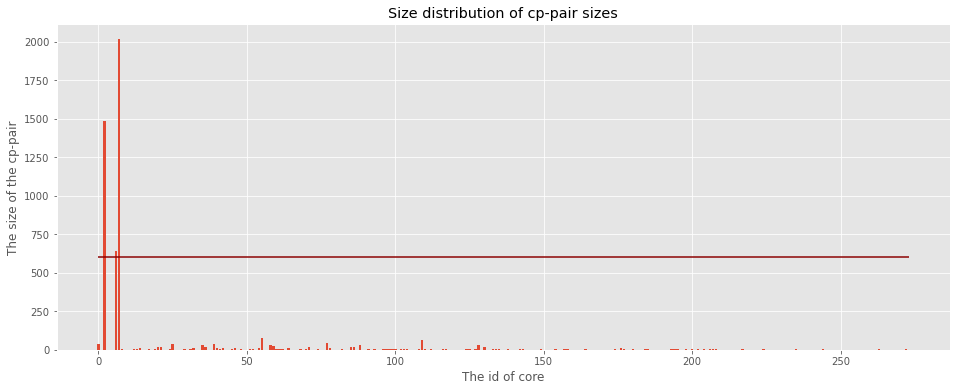

In [9]:
n_cores, core_ids = estimate_number_of_cores(encoded_networks["kokoomus"], visualize=True, threshold=0.3)

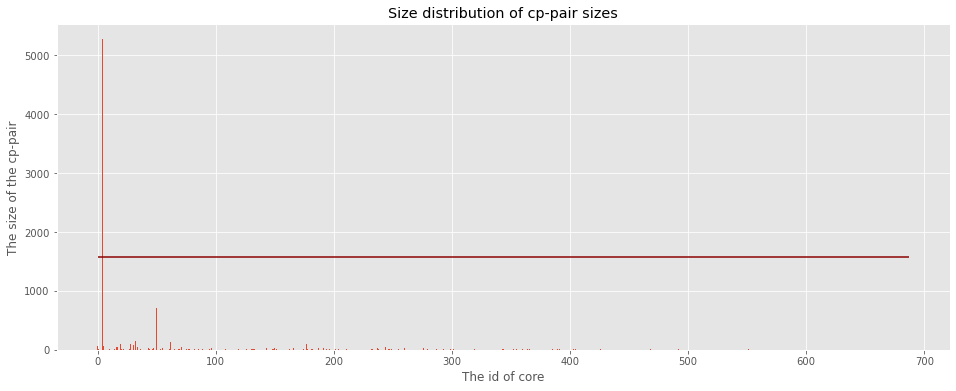

In [10]:
n_cores, core_ids = estimate_number_of_cores(encoded_networks["ilmastonmuutos"], visualize=True, threshold=0.3)

Perform "sensitivity analysis"

In [11]:
n_cores_variation_dict = dict()
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for t in selected_topics:
    
    n_cores_variation = dict()
    
    for th in thresholds:
        n_cores, _ = estimate_number_of_cores(encoded_networks[t], visualize=False, threshold=th)
        n_cores_variation[th] = n_cores
    
    n_cores_variation_dict[t] = n_cores_variation

Let us also take the effect of the network size to the robustness of number of cores

In [12]:
network_sizes = [len(g) for g in encoded_networks.values()]
network_edges = [len(g.edges) for g in encoded_networks.values()]

View the results

In [13]:
df = pd.DataFrame.from_dict(n_cores_variation_dict).T
df["|N|"] = network_sizes
df["|E|"] = network_sizes
df

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,|N|,|E|
kokoomus,3,3,3,2,2,2,2,1,1,5548,5548
vihreät,3,3,2,2,2,2,1,1,1,3353,3353
perussuomalaiset,3,1,1,1,1,1,1,1,1,2027,2027
vasemmisto,3,2,2,2,1,1,1,1,1,3646,3646
vihapuhe,4,1,1,1,1,1,1,1,1,1865,1865
ilmastonmuutos,2,1,1,1,1,1,1,1,1,10164,10164
maahanmuutto,3,2,1,1,1,1,1,1,1,2614,2614
sote,1,1,1,1,1,1,1,1,1,8920,8920
ilmastovaalit,1,1,1,1,1,1,1,1,1,5124,5124
keskusta,4,4,3,2,2,1,1,1,1,4438,4438


Visualize the network with identified core-periphery pairs

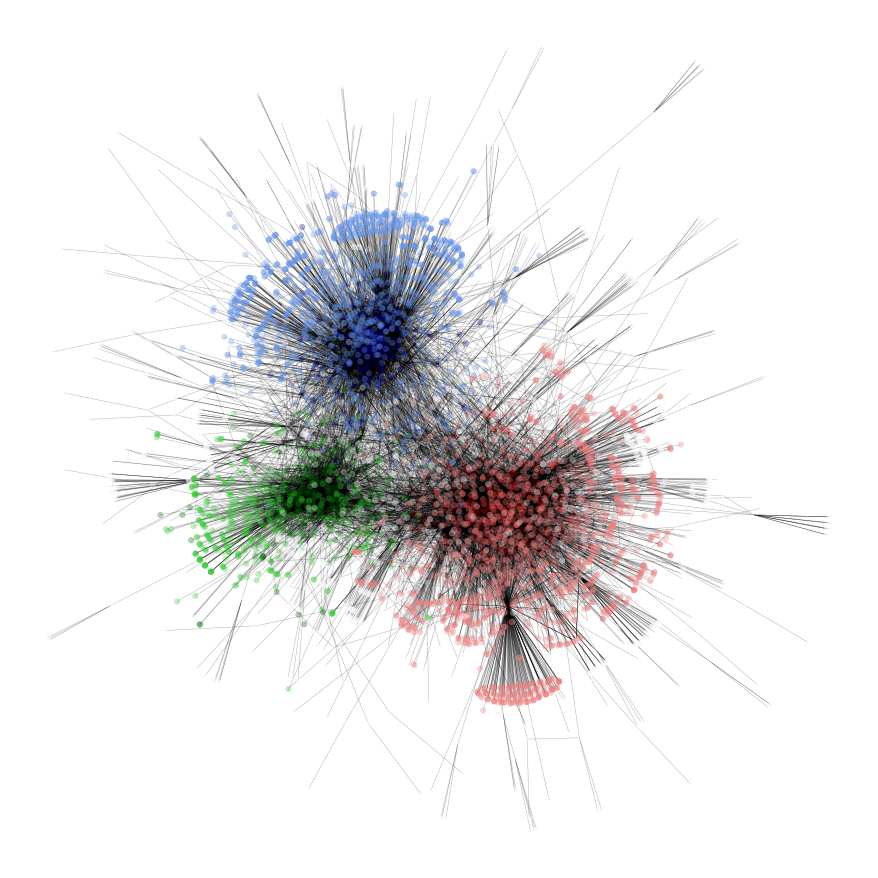

In [14]:
topic = "kokoomus"
G = encoded_networks[topic]
n_cores, core_ids = estimate_number_of_cores(encoded_networks[topic], visualize=False, threshold=0.3)
visualize_cpp(G, core_ids)

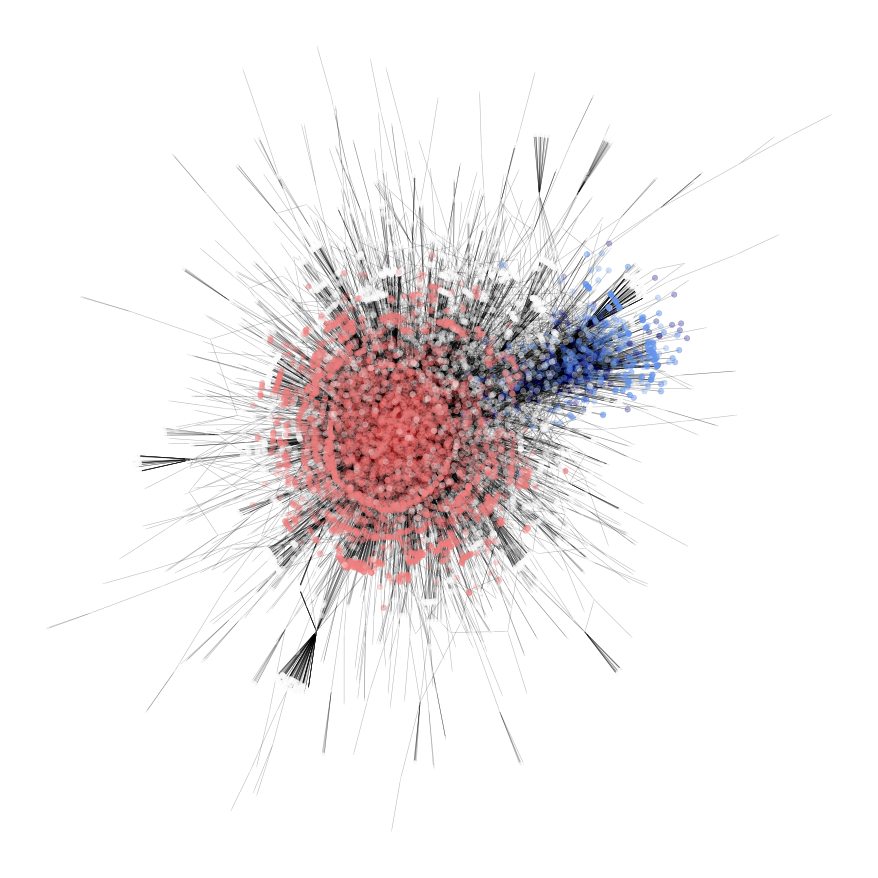

In [15]:
topic = "ilmastonmuutos"
G = encoded_networks[topic]
n_cores, core_ids = estimate_number_of_cores(encoded_networks[topic], visualize=False, threshold=0.1)
visualize_cpp(G, core_ids)

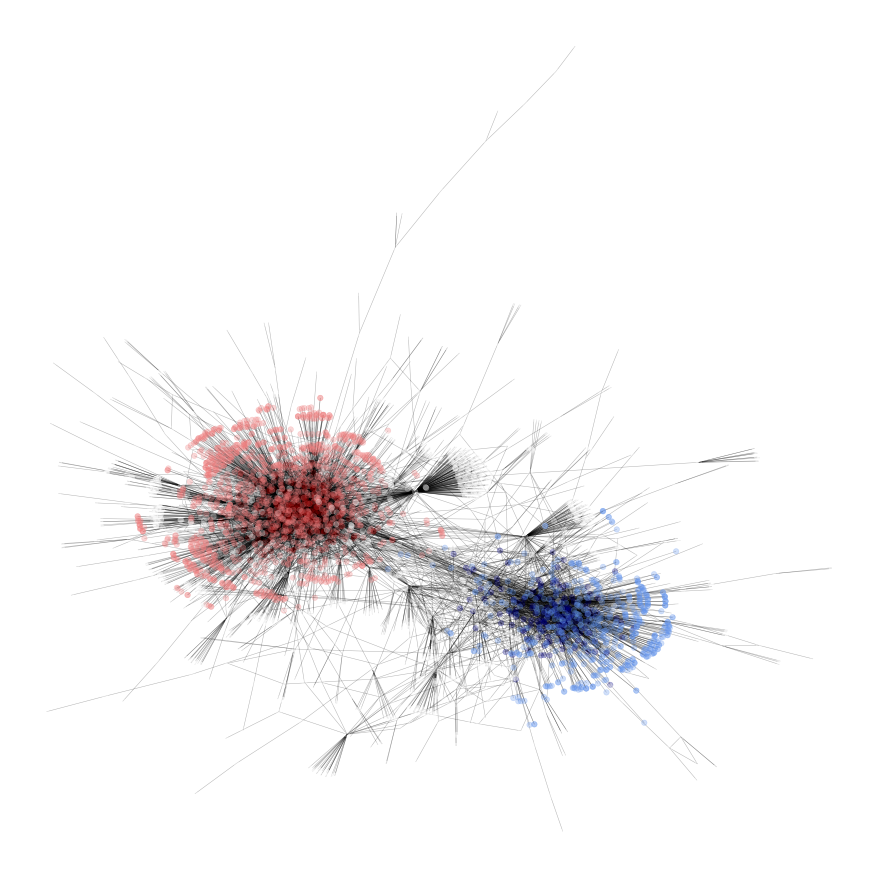

In [16]:
topic = "vasemmisto"
G = encoded_networks[topic]
n_cores, core_ids = estimate_number_of_cores(encoded_networks[topic], visualize=False, threshold=0.3)
visualize_cpp(G, core_ids)

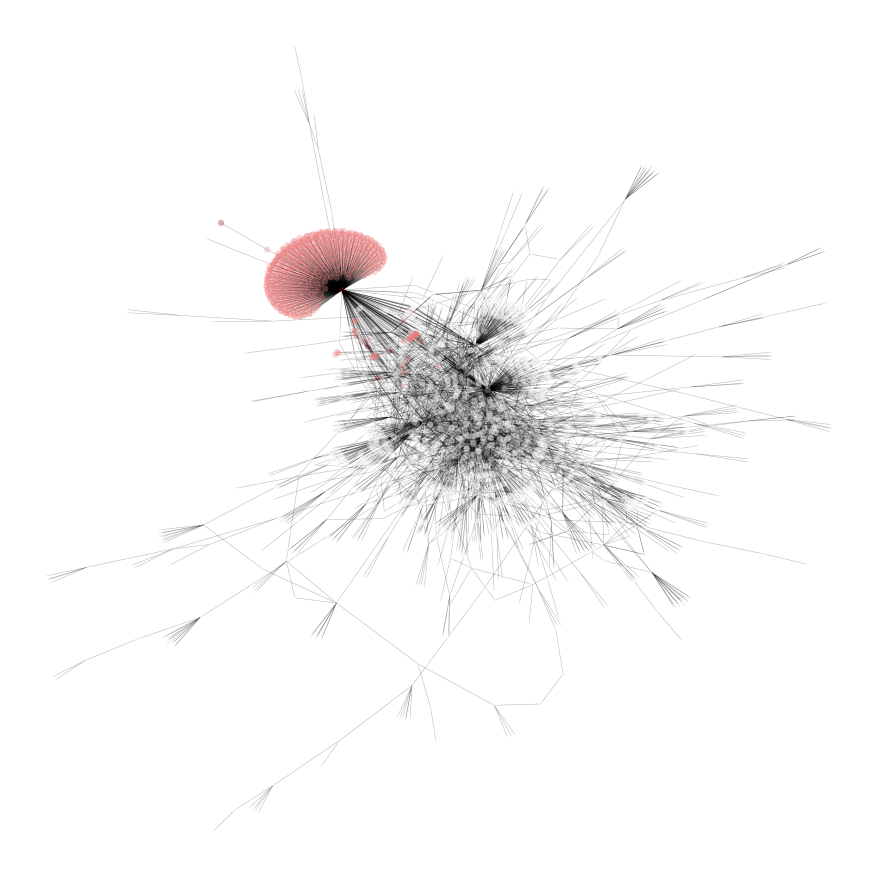

In [17]:
topic = "mielenterveys"
G = encoded_networks[topic]
n_cores, core_ids = estimate_number_of_cores(encoded_networks[topic], visualize=False, threshold=0.3)
visualize_cpp(G, core_ids)

***

### II. FLOW BETWEEN THE CHAMBERS

In [18]:
def build_elite_network(network, core_ids):
    
    # Exctract the cores
    if len(core_ids) == 1:
        print("Only one core detected")
        core_id1 = core_ids[0]
        core1 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id1 and attrlist["coreness"] == 1]
        
        elite_network = network.subgraph(core1)

    elif len(core_ids) == 2:
        core_id1 = core_ids[0]
        core_id2 = core_ids[1]

        core1 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id1 and attrlist["coreness"] == 1]
        core2 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id2 and attrlist["coreness"] == 1]
        
        elite_network = network.subgraph(core1 + core2)

    else:
        core_id1 = core_ids[0]
        core_id2 = core_ids[1]
        core_id3 = core_ids[2]

        core1 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id1 and attrlist["coreness"] == 1]
        core2 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id2 and attrlist["coreness"] == 1]
        core3 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id3 and attrlist["coreness"] == 1]
        
        elite_network = network.subgraph(core1 + core2 + core3)    
        
    return elite_network

In [19]:
def accessibility_score(network, core_ids, p=0.5, k=3):
    
    if len(core_ids) == 1:
        EMD = 0
        M = nx.to_numpy_matrix(network)
        A = sum([(p**i)*(M**i) for i in range(1, k+1)])
        
    elif len(core_ids) == 2:
        
        core_id1 = core_ids[0]
        core_id2 = core_ids[1]

        core1 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id1 and attrlist["coreness"] == 1]
        core2 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id2 and attrlist["coreness"] == 1]

        nodelist = core1 + core2
        M = nx.to_numpy_matrix(network, nodelist=nodelist)

        A = sum([(p**i)*(M**i) for i in range(1, k+1)])

        n_core1 = len(core1)

        core1_intra = A[:n_core1, :n_core1].flatten().tolist()[0]
        core2_intra = A[n_core1:, n_core1:].flatten().tolist()[0]
        core_inter = A[:n_core1, n_core1:].flatten().tolist()[0]

        EMD = wasserstein_distance(core1_intra + core2_intra, core_inter)
        
    else:
        
        core_id1 = core_ids[0]
        core_id2 = core_ids[1]
        core_id3 = core_ids[2]

        core1 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id1 and attrlist["coreness"] == 1]
        core2 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id2 and attrlist["coreness"] == 1]
        core3 = [node for node, attrlist in network.nodes(data=True) if attrlist["pair_id"] == core_id3 and attrlist["coreness"] == 1]

        nodelist = core1 + core2 + core3
        M = nx.to_numpy_matrix(network, nodelist=nodelist)

        A = sum([(p**i)*(M**i) for i in range(1, k+1)])

        n_core1 = len(core1)
        n_core2 = len(core2)
        n_core3 = len(core3)

        core1_intra = A[:n_core1, :n_core1].flatten().tolist()[0]
        core2_intra = A[n_core1:(n_core1 + n_core2), n_core1:(n_core1 + n_core2)].flatten().tolist()[0]
        core3_intra = A[(n_core1 + n_core2):, (n_core1 + n_core2):].flatten().tolist()[0]
        
        core_inter_12 = A[:n_core1, n_core1:(n_core1 + n_core2)].flatten().tolist()[0]
        core_inter_13 = A[:n_core1, (n_core1 + n_core2):].flatten().tolist()[0]
        core_inter_23 = A[n_core1:(n_core1 + n_core2), (n_core1 + n_core2):].flatten().tolist()[0]

        EMD_12 = wasserstein_distance(core1_intra + core2_intra, core_inter_12)
        EMD_13 = wasserstein_distance(core1_intra + core3_intra, core_inter_13)
        EMD_23 = wasserstein_distance(core2_intra + core3_intra, core_inter_23)
        
        # Weighted average
        EMD = ((n_core1+n_core2)*EMD_12 + (n_core1+n_core3)*EMD_13 + (n_core2+n_core3)*EMD_23)/(2*(n_core1+n_core2 + n_core3))
        
    return(EMD, A)

Compute the flow-score that is supposed to capture the elite polarization. For now, the function is able to measure the score for 2 or 3 cores. The approach is scalable. It requires deeper analysis though.

In [ ]:
topic = "kunnat"
G = encoded_networks[topic]
n_cores, core_ids = estimate_number_of_cores(encoded_networks[topic], visualize=False, threshold=0.2)
n_cores

In [20]:
EMD_results = dict()
A_results = dict()
elite_backbone_results = dict()

for t in selected_topics:
    
    G = encoded_networks[t]
    n_cores, core_ids = estimate_number_of_cores(encoded_networks[t], visualize=False, threshold=0.1)
  
    # Take subgraph of whole network with only core nodes
    elite_backbone = build_elite_network(G, core_ids)
    elite_backbone_results[t] = elite_backbone
    
    # For some reasons there is a few disconnected nodes per topic which is odd, for now we just study the largest component
    Gcc = sorted(nx.connected_components(elite_backbone), key=len, reverse=True)
    giant_backbone = G.subgraph(Gcc[0])
    
    EMD, A = accessibility_score(elite_backbone, core_ids, p=0.5, k=3)
    
    EMD_results[t] = EMD
    A_results[t] = A
    
    print("Topic completed: ", t)

Topic completed:  kokoomus
Topic completed:  vihreät
Topic completed:  perussuomalaiset
Topic completed:  vasemmisto
Topic completed:  vihapuhe
Topic completed:  ilmastonmuutos
Topic completed:  maahanmuutto
Only one core detected
Topic completed:  sote
Only one core detected
Topic completed:  ilmastovaalit
Topic completed:  keskusta
Topic completed:  mielenterveys
Topic completed:  liikenne
Topic completed:  kunnat
Topic completed:  tekoäly
Only one core detected
Topic completed:  nuoret
Topic completed:  urheilu
Topic completed:  yrittäjät
Topic completed:  yrittäjyys
Topic completed:  rekry
Topic completed:  osaaminen
Topic completed:  johtaminen


Let us study selected topics closer and look at the results

In [21]:
df = pd.DataFrame(EMD_results, index=[0]).T
df.rename(columns={0: "wasFLOW"}, inplace=True)
df["controversial"] = 10*[1] + 11*[0]
df

,wasFLOW,controversial
kokoomus,11.167389,1
vihreät,3.193737,1
perussuomalaiset,8.011726,1
vasemmisto,7.307029,1
vihapuhe,1.944401,1
ilmastonmuutos,6.938686,1
maahanmuutto,4.394648,1
sote,0.000000,1
ilmastovaalit,0.000000,1
keskusta,2.429127,1


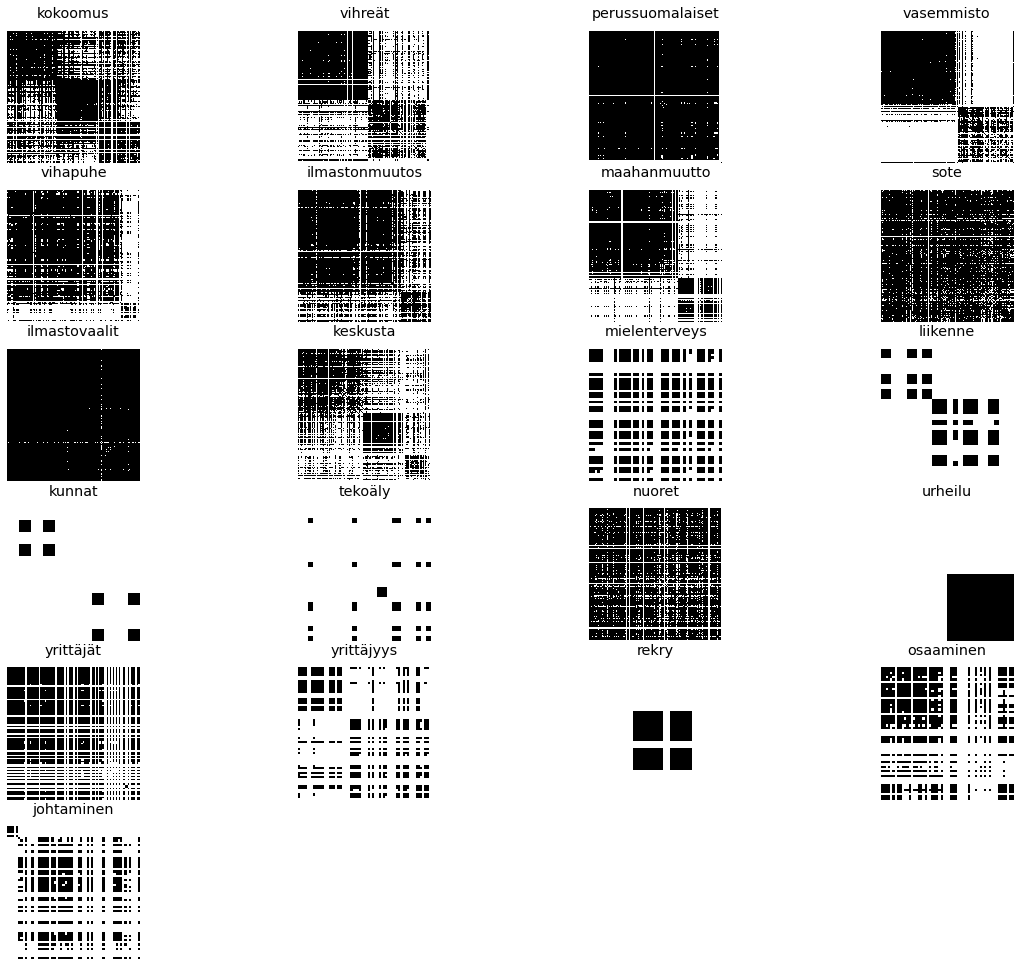

In [22]:
plt.figure(figsize=(20,20))

i = 1
for k in A_results:
    plt.subplot(7,4,i)
    plt.title(k)
    plt.spy(A_results[k])
    plt.axis("off")
    i += 1

Here only the largest connected component of the elite backbone network is plotted. These are the core-periphery structures that the algorithm found.

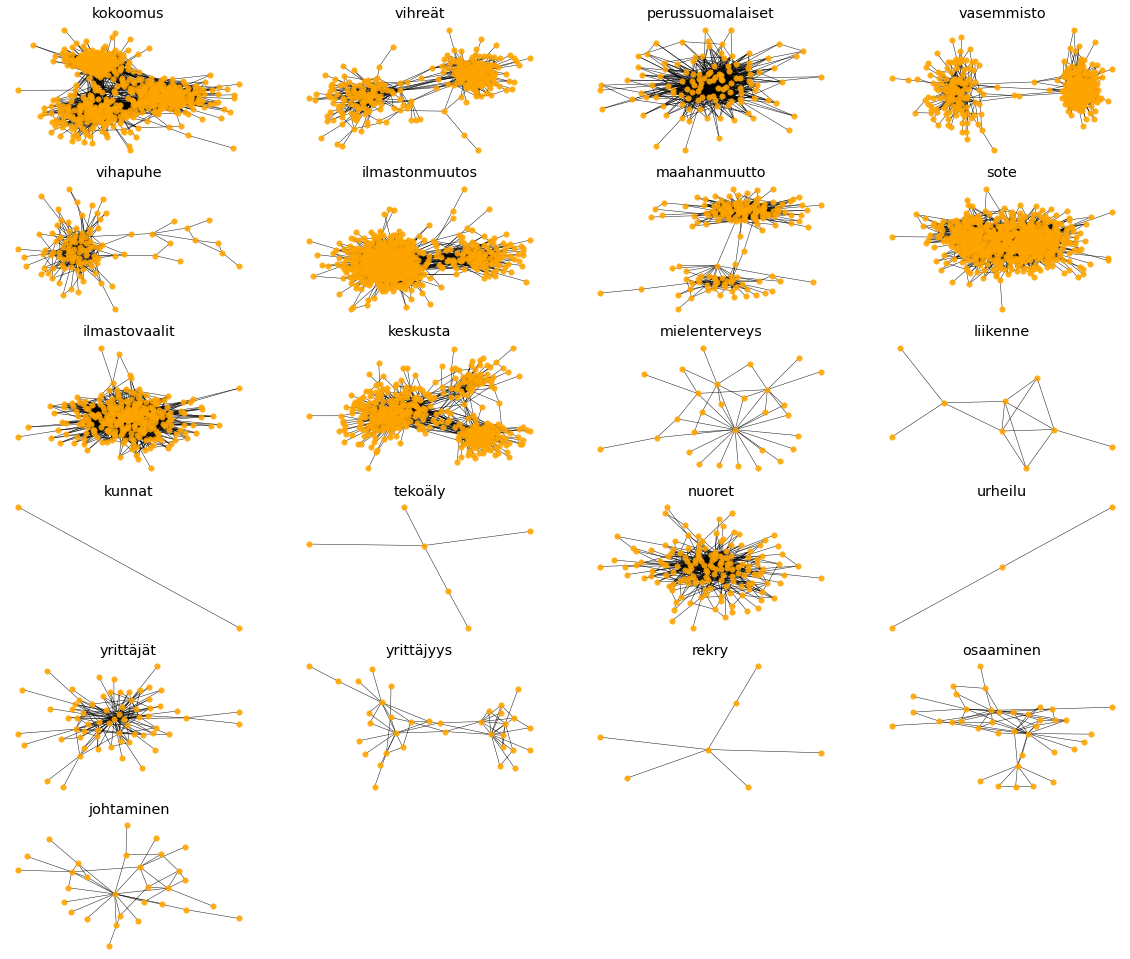

In [23]:
plt.figure(figsize=(20,20))

i = 1
for k in elite_backbone_results:
    plt.subplot(7,4,i)
    plt.title(k)
    G = encoded_networks[k]
    Gcc = sorted(nx.connected_components(elite_backbone_results[k]), key=len, reverse=True)
    giant_backbone = G.subgraph(Gcc[0])
    nx.draw_spring(giant_backbone, node_size=30, width=0.5, alpha=0.9, node_color = "orange")
    i += 1

***

### III. COHESION OF THE CHAMBERS

How close are the bubble/chamber structures to the ideal core-periphery structure?

**Idealised core-periphery is a structure in which core nodes are adjacent to all other nodes, and peripheral nodes are adjacent to all core nodes but not to any peripheral nodes**

In [24]:
# Write this part smarter later
cohesion_results = dict()

for t in selected_topics:
    
    G = encoded_networks[t]
    n_cores, core_ids = estimate_number_of_cores(encoded_networks[t], visualize=False, threshold=0.1)
  
    # Take subgraph of whole network with only core nodes
    core_nodes1 = [node for node, attrlist in G.nodes(data=True) if attrlist["pair_id"] == core_ids[0] and attrlist["coreness"] == 1]
    
    if len(core_ids) != 1:
        core_nodes2 = [node for node, attrlist in G.nodes(data=True) if attrlist["pair_id"] == core_ids[1] and attrlist["coreness"] == 1]
    
    # For some reasons there is a few disconnected nodes per topic which is odd, for now we just study the largest component
    Gcc = sorted(nx.connected_components(elite_backbone), key=len, reverse=True)
    giant_backbone = G.subgraph(Gcc[0])
    
    elite_cohesion1 = nx.density(G.subgraph(core_nodes1))
    elite_cohesion2 = nx.density(G.subgraph(core_nodes2))
    
    #edge_connectivity1 = nx.edge_connectivity(giant_backbone.subgraph(core_nodes1))
    #edge_connectivity2 = nx.edge_connectivity(giant_backbone.subgraph(core_nodes2))
    
    cohesion_results[t] = {"elite_cohesion1": elite_cohesion1, "elite_cohesion2": elite_cohesion2}

In [25]:
df = pd.DataFrame.from_dict(cohesion_results).T
df

,elite_cohesion1,elite_cohesion2
kokoomus,0.065562,0.116874
vihreät,0.075233,0.037248
perussuomalaiset,0.113801,0.000000
vasemmisto,0.086384,0.034387
vihapuhe,0.076684,0.120879
ilmastonmuutos,0.032388,0.034542
maahanmuutto,0.095162,0.079574
sote,0.026410,0.007519
ilmastovaalit,0.080426,0.013158
keskusta,0.031687,0.067204


## SUPPLEMENTARY

## for all topics

In [27]:
encoded_networks = dict()

for t in topic_dict.keys():
    
    network = GL[topic_dict[t]][0][0][0]
    encoded_networks[t] = cpp_identification(network, n_runs = 40)
    print("Topic completed: ", t)

Topic completed:  aktiivimalli
Topic completed:  ammatillinenkoulutus
Topic completed:  arvot
Topic completed:  demokratia
Topic completed:  digitalisaatio
Topic completed:  eduskunta
Topic completed:  eduskuntavaalit2019
Topic completed:  eduskuntavaalit
Topic completed:  eriarvoisuus
Topic completed:  eu
Topic completed:  fridaysforfuture
Topic completed:  hallitus
Topic completed:  helsinki
Topic completed:  hoitajamitoitus
Topic completed:  hyvinvointi
Topic completed:  ihmisoikeudet
Topic completed:  ilmasto
Topic completed:  ilmastolakko
Topic completed:  ilmastomarssi
Topic completed:  ilmastonmuutos
Topic completed:  ilmastovaalit
Topic completed:  johtaminen
Topic completed:  jotainrajaa
Topic completed:  journalismi
Topic completed:  kasvu
Topic completed:  keskusta
Topic completed:  kokoomus
Topic completed:  korvaamaton
Topic completed:  koulutus
Topic completed:  koulutusratkaisee
Topic completed:  koulutustaprkl
Topic completed:  kunnat
Topic completed:  köyhyys
Topic com

In [28]:
EMD_results = dict()
A_results = dict()
elite_backbone_results = dict()

for t in topic_dict.keys():
    
    G = encoded_networks[t]
    n_cores, core_ids = estimate_number_of_cores(encoded_networks[t], visualize=False, threshold=0.1)
  
    # Take subgraph of whole network with only core nodes
    elite_backbone = build_elite_network(G, core_ids)
    elite_backbone_results[t] = elite_backbone
    
    # For some reasons there is a few disconnected nodes per topic which is odd, for now we just study the largest component
    Gcc = sorted(nx.connected_components(elite_backbone), key=len, reverse=True)
    giant_backbone = G.subgraph(Gcc[0])
    
    EMD, A = accessibility_score(elite_backbone, core_ids, p=0.5, k=3)
    
    EMD_results[t] = EMD
    A_results[t] = A
    
    #print("Topic completed: ", t)

Only one core detected
Only one core detected
Only one core detected
Only one core detected
Only one core detected
Only one core detected
Only one core detected
Only one core detected


In [67]:
df = pd.DataFrame(EMD_results, index=[0]).T
df["english (googled)"] = ['active model', 'vocational training', 'values', 'democracy', 'digitalisation', 'parliament', 'parliamentary elections2019','parliamentary elections', 'inequality', 'eu', 'fridaysforfuture', 'government' , 'helsinki', 'caretaker', 'well-being', 'human rights',' climate ',' climate strike ',' climate march ',' climate change ',' climate elections', 'leadership', 'something of a limit', 'journalism', ' growth ',' downtown ',' coalition ',' priceless', 'education', 'educational solutions',' education training ',' municipalities', 'poverty', 'childrens rights',' children ',' transport ',' nature ' , 'immigration', 'provincial reform', 'free22', 'forest', 'mental health', 'diversity', 'youth', 'forced', 'your nature', 'skills',' inclusion ',' oulu ',' persut ',' Basic Finns', 'basic income', 'constitution', 'pirates',' police ',' politics', 'racism', 'recruitment', 'same direction', 'freedom of speech', 'sdp', 'ziksitiede' , 'you decide', 'social security', 'sote', 'economy', 'tampere', 'equality', 'artificial intelligence', 'health', 'science', ' scientific elections', 'future', 'future line', 'turku', 'Turpo', 'security', 'research', 'work', 'working life', 'employment', 'sport', 'election machine', 'elections19' , 'elections2019', 'elections',' election exam ',' elderlycare ',' left ',' taxation ',' communication ',' hate speech ',' greens', 'equality', 'Yle', 'yleastudio', ' university ',' environment ',' entrepreneurship ','entrepreneurs']
df.rename(columns={0: "wasFLOW"}, inplace=True)
df = df.sort_values(by=['wasFLOW'], ascending=False)
columns_titles = ["english (googled)", "wasFLOW"]
df=df.reindex(columns=columns_titles)
df.head(50)

,english (googled),wasFLOW
ilmasto,climate,19.716129
samasuunta,same direction,17.625428
piraatit,pirates,14.727194
vaalit,elections,13.410792
kokoomus,coalition,11.355884
vaalit2019,elections2019,10.688507
vasemmisto,left,8.111343
ilmastolakko,climate strike,7.776537
tulevaisuuslinja,future line,7.281932
ilmastonmuutos,climate change,6.974921


In [60]:
df.tail(50)

,wasFLOW,english
luonto,0.717349,nature
vaalitentti,0.715803,election exam
metsä,0.686416,forest
yliopisto,0.618828,university
ammatillinenkoulutus,0.602624,vocational training
yrittäjyys,0.573663,entrepreneurship
hyvinvointi,0.528232,well-being
yleastudio,0.511303,yleastudio
sosiaaliturva,0.504743,social security
työelämä,0.498064,working life
